# Driver Data Extraction - Step by Step with Diagnostics

This notebook walks through the climate driver importance extraction process from TFT model predictions, with detailed diagnostics at each step.

Based on: `/burg-archive/home/al4385/phenofusion/src/phenofusion/dataio/driversdata.py`

## Step 1: Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
from scipy.stats import linregress
from typing import List, Tuple, Optional
import logging
import matplotlib.pyplot as plt
import seaborn as sns

# Configure logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Step 2: Configure Parameters

Set the file paths and parameters for the analysis.

In [21]:
# Configuration
PFT = "SHR"  # Plant functional type
FORECAST_WINDOW = 30  # Days

# File paths
DATA_PATH = f"/burg/glab/users/al4385/data/TFT_40_overlapping_samples/{PFT}_1982_2021.pkl"
PRED_PATH = f"/burg/glab/users/al4385/predictions/pred_40year_moresamples/{PFT}_20251023.pkl"
COORD_PATH = f"/burg/glab/users/al4385/data/coordinates/{PFT}.parquet"
OUTPUT_BASE = f"/burg/glab/users/ms7073/analysis/driversdata/oversampling/{PFT}_diagnostic"

# Phenology detection thresholds
MIN_DIFF = 0.01 if PFT in ["BET", "SHR"] else 0.20
MIN_SLOPE = 0.001 if PFT in ["BET", "SHR"] else 0.002

print(f"Configuration:")
print(f"  PFT: {PFT}")
print(f"  Forecast Window: {FORECAST_WINDOW} days")
print(f"  Min CSIF Difference: {MIN_DIFF}")
print(f"  Min Slope: {MIN_SLOPE}")
print(f"\nFile paths:")
print(f"  Data: {DATA_PATH}")
print(f"  Predictions: {PRED_PATH}")
print(f"  Coordinates: {COORD_PATH}")

Configuration:
  PFT: SHR
  Forecast Window: 30 days
  Min CSIF Difference: 0.01
  Min Slope: 0.001

File paths:
  Data: /burg/glab/users/al4385/data/TFT_40_overlapping_samples/SHR_1982_2021.pkl
  Predictions: /burg/glab/users/al4385/predictions/pred_40year_moresamples/SHR_20251023.pkl
  Coordinates: /burg/glab/users/al4385/data/coordinates/SHR.parquet


## Step 3: Load Data Files

Load the processed data, predictions, and coordinates.

In [3]:
# Load original data
print("Loading data...")
with open(DATA_PATH, "rb") as fp:
    data = pickle.load(fp)

print(f"✓ Data loaded")
print(f"  Keys: {list(data.keys())}")
print(f"  Data sets: {list(data['data_sets'].keys())}")

Loading data...
✓ Data loaded
  Keys: ['data_sets', 'feature_map', 'scalers', 'categorical_cardinalities']
  Data sets: ['train', 'validation', 'test']


/burg-archive/home/al4385/.local/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator QuantileTransformer from version 1.3.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/burg-archive/home/al4385/.local/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/burg-archive/home/al4385/.local/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder 

In [6]:
# Load predictions
print("Loading predictions...")
with open(PRED_PATH, "rb") as fp:
    preds = pickle.load(fp)

print(f"✓ Predictions loaded")
print(f"  Keys: {list(preds.keys())}")
print(f"  Attention scores shape: {preds['attention_scores'].shape}")
print(f"  Predicted quantiles shape: {preds['predicted_quantiles'].shape}")
print(f"  Historical selection weights shape: {preds['historical_selection_weights'].shape}")

Loading predictions...
✓ Predictions loaded
  Keys: ['predicted_quantiles', 'static_weights', 'historical_selection_weights', 'future_selection_weights', 'attention_scores']
  Attention scores shape: (722881, 30, 395)
  Predicted quantiles shape: (722881, 30, 3)
  Historical selection weights shape: (722881, 365, 7)


In [7]:
# Load coordinates
print("Loading coordinates...")
coords = pd.read_parquet(COORD_PATH).drop_duplicates()

print(f"✓ Coordinates loaded")
print(f"  Shape: {coords.shape}")
print(f"  Columns: {list(coords.columns)}")
print(f"  Unique locations: {coords['location'].nunique()}")
print(f"\nFirst few rows:")
coords.head()

Loading coordinates...
✓ Coordinates loaded
  Shape: (3564, 3)
  Columns: ['location', 'latitude', 'longitude']
  Unique locations: 3564

First few rows:


,location,latitude,longitude
0,0,44.25,-118.25
1,1,44.25,-118.00
2,2,44.25,-117.75
3,3,44.25,-117.50
4,4,44.25,-113.75


## Step 4: Examine Test Data Structure

In [8]:
# Extract test data
test_data = data["data_sets"]["test"]

print("Test data structure:")
print(f"  Keys: {list(test_data.keys())}")
print(f"\nShapes:")
for key, value in test_data.items():
    if hasattr(value, 'shape'):
        print(f"  {key}: {value.shape}")
    else:
        print(f"  {key}: {type(value)}")

print(f"\nFirst few IDs:")
print(test_data['id'][:5].flatten())

print(f"\nFirst few target values (CSIF):")
print(test_data['target'][:5].flatten())

Test data structure:
  Keys: ['time_index', 'static_feats_numeric', 'static_feats_categorical', 'historical_ts_numeric', 'historical_ts_categorical', 'future_ts_numeric', 'future_ts_categorical', 'target', 'id']

Shapes:
  time_index: (722881,)
  static_feats_numeric: (722881, 2)
  static_feats_categorical: (722881, 1)
  historical_ts_numeric: (722881, 365, 7)
  historical_ts_categorical: (722881, 365, 0)
  future_ts_numeric: (722881, 30, 6)
  future_ts_categorical: (722881, 30, 0)
  target: (722881, 30)
  id: (722881, 30)

First few IDs:
['0_1983-01-15' '0_1983-01-16' '0_1983-01-17' '0_1983-01-18'
 '0_1983-01-19' '0_1983-01-20' '0_1983-01-21' '0_1983-01-22'
 '0_1983-01-23' '0_1983-01-24' '0_1983-01-25' '0_1983-01-26'
 '0_1983-01-27' '0_1983-01-28' '0_1983-01-29' '0_1983-01-30'
 '0_1983-01-31' '0_1983-02-01' '0_1983-02-02' '0_1983-02-03'
 '0_1983-02-04' '0_1983-02-05' '0_1983-02-06' '0_1983-02-07'
 '0_1983-02-08' '0_1983-02-09' '0_1983-02-10' '0_1983-02-11'
 '0_1983-02-12' '0_1983-02-1

## Step 5: Create Analysis DataFrame

Combine data, predictions, and coordinates into a single DataFrame.

In [9]:
# Create base DataFrame
df = pd.DataFrame(
    {
        "Index": test_data["id"].flatten(),
        "CSIF": test_data["target"].flatten(),
    }
)

# Add predictions (median/0.5 quantile)
df["pred_05"] = preds["predicted_quantiles"][:, :, 1].flatten()

print(f"Base DataFrame created:")
print(f"  Shape: {df.shape}")
print(f"  Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head(10)

Base DataFrame created:
  Shape: (21686430, 3)
  Columns: ['Index', 'CSIF', 'pred_05']

First few rows:


,Index,CSIF,pred_05
0,0_1983-01-15,-0.492586,-0.504294
1,0_1983-01-16,-0.488832,-0.500064
2,0_1983-01-17,-0.484625,-0.496835
3,0_1983-01-18,-0.479965,-0.491568
4,0_1983-01-19,-0.474851,-0.483385
5,0_1983-01-20,-0.469285,-0.478218
6,0_1983-01-21,-0.463265,-0.471750
7,0_1983-01-22,-0.457245,-0.464515
8,0_1983-01-23,-0.451225,-0.459697
9,0_1983-01-24,-0.445205,-0.453536


In [10]:
# Parse location and time from Index
df[["location", "time"]] = df["Index"].str.split("_", n=1, expand=True)
df["location"] = df["location"].astype(int)
df["time"] = pd.to_datetime(df["time"])

# Sort by location and time
df = df.sort_values(by=["location", "time"])

# Add temporal features
df["doy"] = df["time"].dt.dayofyear
df["year"] = df["time"].dt.year
df["month"] = df["time"].dt.month
df["day"] = df["time"].dt.day

# Drop index column
df = df.drop(columns=["Index"])

print(f"After parsing temporal information:")
print(f"  Shape: {df.shape}")
print(f"  Columns: {list(df.columns)}")
print(f"  Date range: {df['time'].min()} to {df['time'].max()}")
print(f"  Year range: {df['year'].min()} to {df['year'].max()}")
print(f"\nFirst few rows:")
df.head(10)

After parsing temporal information:
  Shape: (21686430, 8)
  Columns: ['CSIF', 'pred_05', 'location', 'time', 'doy', 'year', 'month', 'day']
  Date range: 1983-01-15 00:00:00 to 2021-12-30 00:00:00
  Year range: 1983 to 2021

First few rows:


,CSIF,pred_05,location,time,doy,year,month,day
0,-0.492586,-0.504294,0,1983-01-15,15,1983,1,15
1,-0.488832,-0.500064,0,1983-01-16,16,1983,1,16
2,-0.484625,-0.496835,0,1983-01-17,17,1983,1,17
3,-0.479965,-0.491568,0,1983-01-18,18,1983,1,18
4,-0.474851,-0.483385,0,1983-01-19,19,1983,1,19
5,-0.469285,-0.478218,0,1983-01-20,20,1983,1,20
6,-0.463265,-0.471750,0,1983-01-21,21,1983,1,21
7,-0.457245,-0.464515,0,1983-01-22,22,1983,1,22
8,-0.451225,-0.459697,0,1983-01-23,23,1983,1,23
9,-0.445205,-0.453536,0,1983-01-24,24,1983,1,24


In [11]:
# Merge with coordinates
df = pd.merge(coords, df, on="location", how="left")

print(f"After merging with coordinates:")
print(f"  Shape: {df.shape}")
print(f"  Columns: {list(df.columns)}")
print(f"  Unique locations: {df['location'].nunique()}")
print(f"  Records per location (avg): {len(df) / df['location'].nunique():.1f}")
print(f"\nSpatial extent:")
print(f"  Latitude range: {df['latitude'].min():.2f} to {df['latitude'].max():.2f}")
print(f"  Longitude range: {df['longitude'].min():.2f} to {df['longitude'].max():.2f}")
print(f"\nFirst few rows:")
df.head()

After merging with coordinates:
  Shape: (21686431, 10)
  Columns: ['location', 'latitude', 'longitude', 'CSIF', 'pred_05', 'time', 'doy', 'year', 'month', 'day']
  Unique locations: 3564
  Records per location (avg): 6084.9

Spatial extent:
  Latitude range: -38.75 to 44.25
  Longitude range: -120.75 to 140.50

First few rows:


,location,latitude,longitude,CSIF,pred_05,time,doy,year,month,day
0,0,44.25,-118.25,-0.492586,-0.504294,1983-01-15,15.0,1983.0,1.0,15.0
1,0,44.25,-118.25,-0.488832,-0.500064,1983-01-16,16.0,1983.0,1.0,16.0
2,0,44.25,-118.25,-0.484625,-0.496835,1983-01-17,17.0,1983.0,1.0,17.0
3,0,44.25,-118.25,-0.479965,-0.491568,1983-01-18,18.0,1983.0,1.0,18.0
4,0,44.25,-118.25,-0.474851,-0.483385,1983-01-19,19.0,1983.0,1.0,19.0


## Step 6: Visualize CSIF Time Series Examples

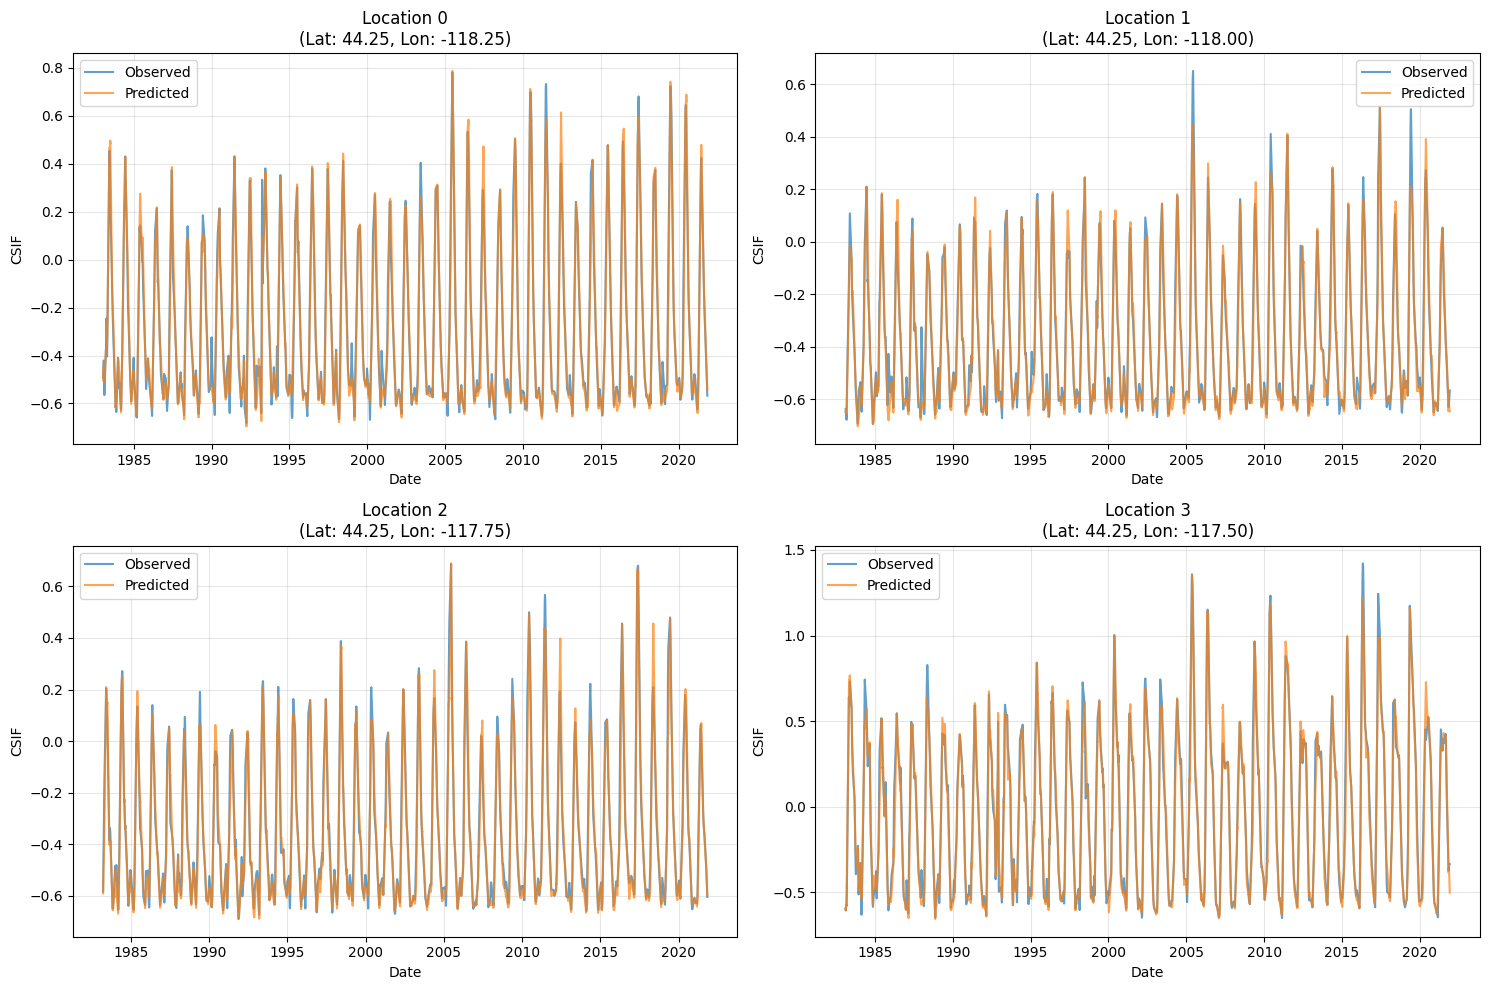

Sample CSIF time series plotted for 4 locations


In [12]:
# Plot CSIF time series for a few random locations
sample_locations = df['location'].unique()[:4]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, loc in enumerate(sample_locations):
    loc_data = df[df['location'] == loc].sort_values('time')
    
    axes[idx].plot(loc_data['time'], loc_data['CSIF'], label='Observed', alpha=0.7)
    axes[idx].plot(loc_data['time'], loc_data['pred_05'], label='Predicted', alpha=0.7)
    axes[idx].set_title(f'Location {loc}\n(Lat: {loc_data["latitude"].iloc[0]:.2f}, Lon: {loc_data["longitude"].iloc[0]:.2f})')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('CSIF')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Sample CSIF time series plotted for 4 locations")

## Step 7: Detect Phenology Indices (SOS and EOS)

Use CSIF slope analysis to identify Start of Season (SOS) and End of Season (EOS) samples.

In [22]:
# Initialize lists for phenology indices
SOS_indices = []
EOS_indices = []
slopes_sos = []  # Store slopes for diagnostics
slopes_eos = []
csif_ranges_sos = []
csif_ranges_eos = []

batch_size = FORECAST_WINDOW 
sos_count = 0
eos_count = 0
skipped_incomplete = 0
skipped_multi_location = 0
skipped_low_signal = 0
skipped_nan = 0  


print(f"Scanning {len(df)} records in batches of {batch_size}...\n")

for start in range(0, len(df), batch_size):
    batch_df = df.iloc[start : start + batch_size]

    if batch_df["CSIF"].isna().any():
        skipped_nan += 1
        continue
    # Skip incomplete batches
    if len(batch_df) < batch_size:
        skipped_incomplete += 1
        continue
    
    # Check if batch is from same location
    if batch_df["location"].nunique() > 1:
        skipped_multi_location += 1
        continue
    
    # Get CSIF values
    csif_values = batch_df["CSIF"].values
    
    # Check if there's sufficient signal
    csif_range = abs(csif_values[-1] - csif_values[0])
    if csif_range < MIN_DIFF:
        skipped_low_signal += 1
        continue
    
    # Calculate slope
    x = np.arange(len(csif_values))
    slope, _, _, _, _ = linregress(x, csif_values)
    
    # Classify as SOS or EOS based on slope
    if slope >= MIN_SLOPE:
        # Positive slope = Start of Season
        SOS_indices.append(batch_df.index[0])
        slopes_sos.append(slope)
        csif_ranges_sos.append(csif_range)
        sos_count += 1
    elif slope <= -MIN_SLOPE - 0.0005:
        # Negative slope = End of Season
        EOS_indices.append(batch_df.index[0])
        slopes_eos.append(slope)
        csif_ranges_eos.append(csif_range)
        eos_count += 1

print(f"Phenology Detection Results:")
print(f"  Total batches processed: {len(df) // batch_size}")
print(f"  Skipped (incomplete): {skipped_incomplete}")
print(f"  Skipped (multi-location): {skipped_multi_location}")
print(f"  Skipped (low signal): {skipped_low_signal}")
print(f"\n  SOS samples detected: {sos_count}")
print(f"  EOS samples detected: {eos_count}")
print(f"  Skipped (NaNs): {skipped_nan}")

if sos_count > 0:
    print(f"\n  SOS slopes: min={min(slopes_sos):.6f}, max={max(slopes_sos):.6f}, mean={np.mean(slopes_sos):.6f}")
    print(f"  SOS CSIF ranges: min={min(csif_ranges_sos):.4f}, max={max(csif_ranges_sos):.4f}, mean={np.mean(csif_ranges_sos):.4f}")

if eos_count > 0:
    print(f"\n  EOS slopes: min={min(slopes_eos):.6f}, max={max(slopes_eos):.6f}, mean={np.mean(slopes_eos):.6f}")
    print(f"  EOS CSIF ranges: min={min(csif_ranges_eos):.4f}, max={max(csif_ranges_eos):.4f}, mean={np.mean(csif_ranges_eos):.4f}")

Scanning 21686431 records in batches of 30...

Phenology Detection Results:
  Total batches processed: 722881
  Skipped (incomplete): 1
  Skipped (multi-location): 2767
  Skipped (low signal): 40521

  SOS samples detected: 252146
  EOS samples detected: 277548

  SOS slopes: min=0.001000, max=0.264768, mean=0.012202
  SOS CSIF ranges: min=0.0100, max=6.3697, mean=0.5297

  EOS slopes: min=-0.111188, max=-0.001500, mean=-0.010939
  EOS CSIF ranges: min=0.0100, max=5.9353, mean=0.5328


In [23]:
print(f"  Skipped (NaNs): {skipped_nan}")


  Skipped (multi-location): 1


In [24]:
# Convert to prediction indices
SOS_pred_indices = [int(i / batch_size) for i in SOS_indices]
EOS_pred_indices = [int(i / batch_size) for i in EOS_indices]

# Filter out indices beyond prediction array bounds
max_pred_index = len(preds["attention_scores"]) - 1
SOS_pred_indices = [idx for idx in SOS_pred_indices if idx <= max_pred_index]
EOS_pred_indices = [idx for idx in EOS_pred_indices if idx <= max_pred_index]

print(f"Prediction Indices:")
print(f"  SOS prediction indices: {len(SOS_pred_indices)} (filtered from {sos_count})")
print(f"  EOS prediction indices: {len(EOS_pred_indices)} (filtered from {eos_count})")
print(f"  Max valid prediction index: {max_pred_index}")

Prediction Indices:
  SOS prediction indices: 252146 (filtered from 252146)
  EOS prediction indices: 277548 (filtered from 277548)
  Max valid prediction index: 722880


## Step 8: Visualize Slope Distributions

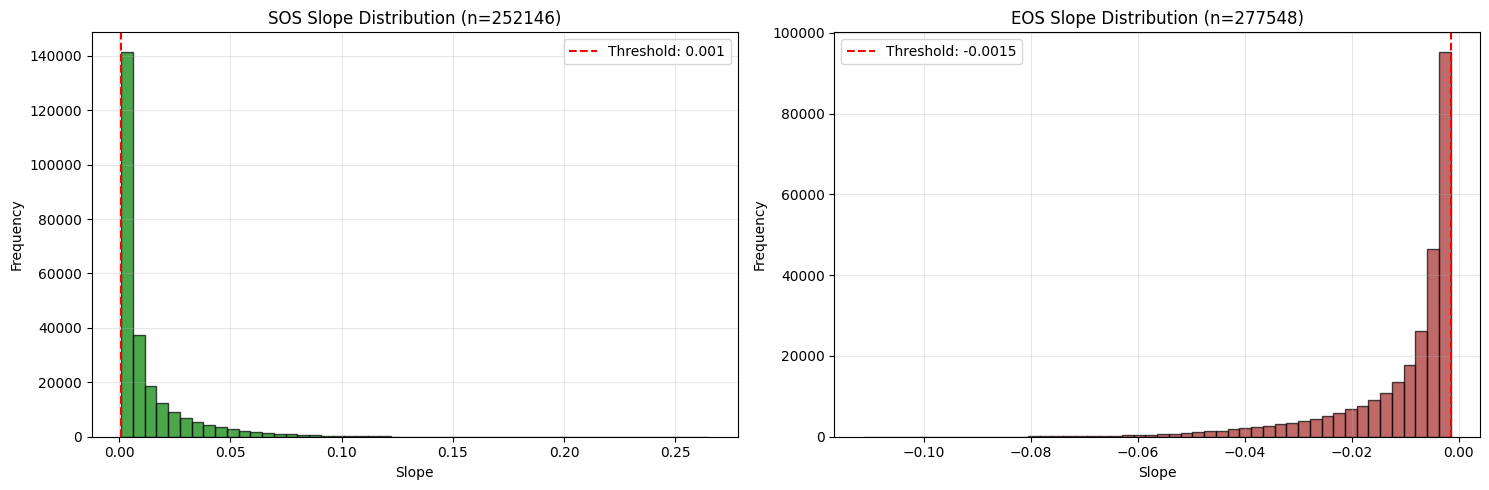

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

if len(slopes_sos) > 0:
    axes[0].hist(slopes_sos, bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[0].axvline(MIN_SLOPE, color='red', linestyle='--', label=f'Threshold: {MIN_SLOPE}')
    axes[0].set_title(f'SOS Slope Distribution (n={len(slopes_sos)})')
    axes[0].set_xlabel('Slope')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

if len(slopes_eos) > 0:
    axes[1].hist(slopes_eos, bins=50, alpha=0.7, color='brown', edgecolor='black')
    axes[1].axvline(-MIN_SLOPE - 0.0005, color='red', linestyle='--', label=f'Threshold: {-MIN_SLOPE - 0.0005:.4f}')
    axes[1].set_title(f'EOS Slope Distribution (n={len(slopes_eos)})')
    axes[1].set_xlabel('Slope')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 9: Visualize Example SOS and EOS Windows

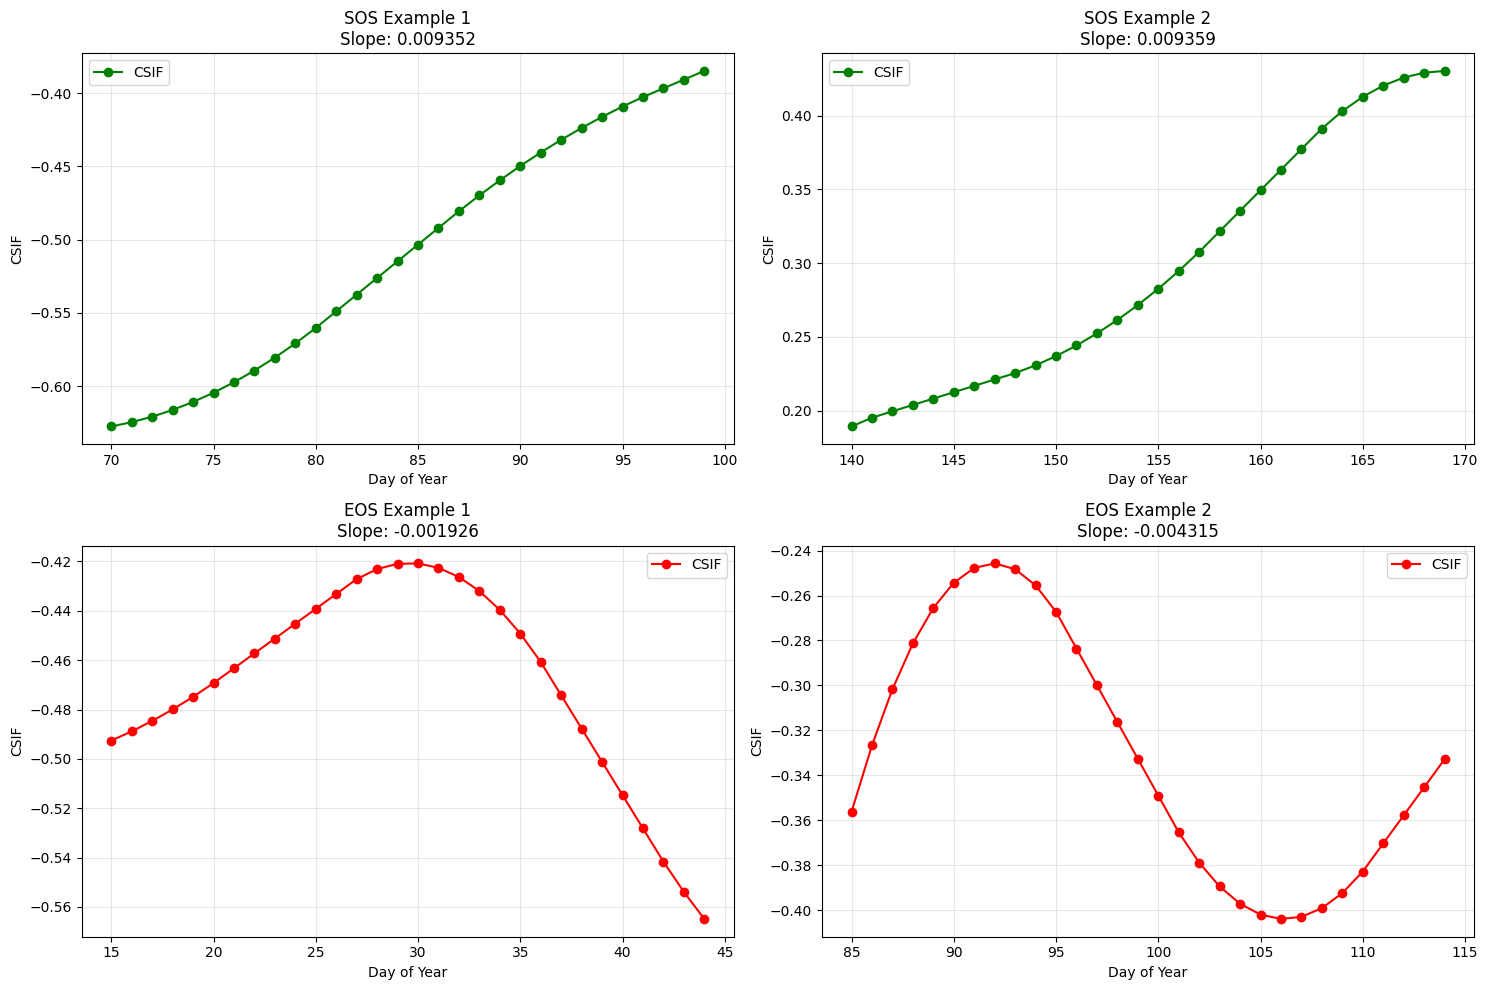

In [26]:
# Plot example SOS and EOS windows
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 2 SOS examples
if len(SOS_indices) >= 2:
    for i in range(2):
        idx = SOS_indices[i]
        window = df.iloc[idx:idx+batch_size]
        axes[0, i].plot(window['doy'], window['CSIF'], 'go-', label='CSIF')
        axes[0, i].set_title(f'SOS Example {i+1}\nSlope: {slopes_sos[i]:.6f}')
        axes[0, i].set_xlabel('Day of Year')
        axes[0, i].set_ylabel('CSIF')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)

# Plot 2 EOS examples
if len(EOS_indices) >= 2:
    for i in range(2):
        idx = EOS_indices[i]
        window = df.iloc[idx:idx+batch_size]
        axes[1, i].plot(window['doy'], window['CSIF'], 'ro-', label='CSIF')
        axes[1, i].set_title(f'EOS Example {i+1}\nSlope: {slopes_eos[i]:.6f}')
        axes[1, i].set_xlabel('Day of Year')
        axes[1, i].set_ylabel('CSIF')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 10: Extract Driver Weights for SOS Samples

For each SOS sample, find the time window with maximum attention and extract driver importance weights.

In [28]:
def find_max_attention_window(index: int, preds, forecast_window: int) -> int:
    """
    Find the time window with maximum attention scores.
    """
    # Get mean attention across all horizons
    att_array = np.mean(preds["attention_scores"][index], axis=0)
    
    max_sum = -np.inf
    best_start_index = None
    
    # Slide window to find maximum
    #max_start = len(att_array) - forecast_window
    max_start = 336
    for i in range(max_start):
        current_sum = np.sum(att_array[i : i + forecast_window])
        if current_sum > max_sum:
            max_sum = current_sum
            best_start_index = i
    
    return best_start_index if best_start_index is not None else 0

print("Extracting SOS driver weights...")

sos_driver_data = []
max_window_start = 365 - FORECAST_WINDOW
skipped_window = 0
processed = 0

for index in SOS_pred_indices[:5]:  # Show diagnostics for first 5
    try:
        # Find maximum attention window
        window_start = find_max_attention_window(index, preds, FORECAST_WINDOW)
        
        print(f"\nSample {index}:")
        print(f"  Max attention window starts at day: {window_start}")
        
        # Skip if window extends beyond valid range
        if window_start > max_window_start:
            print(f"  Skipped: window extends beyond valid range")
            skipped_window += 1
            continue
        
        # Extract median weights for each driver
        weights = {}
        hist_weights = preds["historical_selection_weights"][index]
        
        driver_names = ["tmin", "tmax", "rad", "precip", "photo", "sm"]
        for i, var in enumerate(driver_names, 1):
            weight_values = hist_weights[
                window_start : window_start + FORECAST_WINDOW, i
            ]
            weights[f"hist_{var}"] = np.median(weight_values)
            print(f"  {var}: {weights[f'hist_{var}']:.4f}")
        
        # Get location ID
        location_id = int(
            data["data_sets"]["test"]["id"][index][0].split("_")[0]
        )
        weights["location"] = location_id
        print(f"  Location: {location_id}")
        
        sos_driver_data.append(weights)
        processed += 1
        
    except Exception as e:
        print(f"  Error processing index {index}: {e}")
        continue

print(f"\nProcessed {processed} samples for diagnostics")
print(f"Total SOS samples to process: {len(SOS_pred_indices)}")

Extracting SOS driver weights...

Sample 6:
  Max attention window starts at day: 335
  tmin: 0.0406
  tmax: 0.0406
  rad: 0.2614
  precip: 0.0459
  photo: 0.0549
  sm: 0.4918
  Location: 0

Sample 7:
  Max attention window starts at day: 335
  tmin: 0.0385
  tmax: 0.0382
  rad: 0.1392
  precip: 0.0413
  photo: 0.0509
  sm: 0.6339
  Location: 0

Sample 12:
  Max attention window starts at day: 335
  tmin: 0.0386
  tmax: 0.0384
  rad: 0.1598
  precip: 0.0419
  photo: 0.0515
  sm: 0.6107
  Location: 0

Sample 17:
  Max attention window starts at day: 335
  tmin: 0.0404
  tmax: 0.0404
  rad: 0.2488
  precip: 0.0455
  photo: 0.0548
  sm: 0.5067
  Location: 0

Sample 20:
  Max attention window starts at day: 335
  tmin: 0.0401
  tmax: 0.0401
  rad: 0.2439
  precip: 0.0451
  photo: 0.0542
  sm: 0.5123
  Location: 0

Processed 5 samples for diagnostics
Total SOS samples to process: 252146


In [29]:
# Process all SOS samples
print("Processing all SOS samples...")

sos_driver_data = []
skipped_window = 0
errors = 0

for index in SOS_pred_indices:
    try:
        window_start = find_max_attention_window(index, preds, FORECAST_WINDOW)
        
        if window_start > max_window_start:
            skipped_window += 1
            continue
        
        weights = {}
        hist_weights = preds["historical_selection_weights"][index]
        
        for i, var in enumerate(["tmin", "tmax", "rad", "precip", "photo", "sm"], 1):
            weights[f"hist_{var}"] = np.median(
                hist_weights[window_start : window_start + FORECAST_WINDOW, i]
            )
        
        location_id = int(
            data["data_sets"]["test"]["id"][index][0].split("_")[0]
        )
        weights["location"] = location_id
        
        sos_driver_data.append(weights)
        
    except Exception as e:
        errors += 1
        continue

# Create DataFrame
sos_driver_df = pd.DataFrame(sos_driver_data)

print(f"\nSOS Driver Extraction Results:")
print(f"  Input samples: {len(SOS_pred_indices)}")
print(f"  Skipped (window): {skipped_window}")
print(f"  Errors: {errors}")
print(f"  Successfully extracted: {len(sos_driver_df)}")
print(f"\nDriver DataFrame shape: {sos_driver_df.shape}")
print(f"Columns: {list(sos_driver_df.columns)}")
print(f"\nFirst few rows:")
sos_driver_df.head()

Processing all SOS samples...

SOS Driver Extraction Results:
  Input samples: 252146
  Skipped (window): 0
  Errors: 0
  Successfully extracted: 252146

Driver DataFrame shape: (252146, 7)
Columns: ['hist_tmin', 'hist_tmax', 'hist_rad', 'hist_precip', 'hist_photo', 'hist_sm', 'location']

First few rows:


,hist_tmin,hist_tmax,hist_rad,hist_precip,hist_photo,hist_sm,location
0,0.040587,0.040580,0.261370,0.045899,0.054947,0.491787,0
1,0.038535,0.038178,0.139186,0.041289,0.050934,0.633859,0
2,0.038610,0.038353,0.159835,0.041944,0.051484,0.610716,0
3,0.040374,0.040353,0.248833,0.045466,0.054806,0.506732,0
4,0.040150,0.040123,0.243923,0.045111,0.054247,0.512320,0


## Step 11: Extract Driver Weights for EOS Samples

In [ ]:
print("Processing all EOS samples...")

eos_driver_data = []
skipped_window = 0
errors = 0

for index in EOS_pred_indices:
    try:
        window_start = find_max_attention_window(index, preds, FORECAST_WINDOW)
        
        if window_start > max_window_start:
            skipped_window += 1
            continue
        
        weights = {}
        hist_weights = preds["historical_selection_weights"][index]
        
        for i, var in enumerate(["tmin", "tmax", "rad", "precip", "photo", "sm"], 1):
            weights[f"hist_{var}"] = np.median(
                hist_weights[window_start : window_start + FORECAST_WINDOW, i]
            )
        
        location_id = int(
            data["data_sets"]["test"]["id"][index][0].split("_")[0]
        )
        weights["location"] = location_id
        
        eos_driver_data.append(weights)
        
    except Exception as e:
        errors += 1
        continue

# Create DataFrame
eos_driver_df = pd.DataFrame(eos_driver_data)

print(f"\nEOS Driver Extraction Results:")
print(f"  Input samples: {len(EOS_pred_indices)}")
print(f"  Skipped (window): {skipped_window}")
print(f"  Errors: {errors}")
print(f"  Successfully extracted: {len(eos_driver_df)}")
print(f"\nDriver DataFrame shape: {eos_driver_df.shape}")
print(f"Columns: {list(eos_driver_df.columns)}")
print(f"\nFirst few rows:")
eos_driver_df.head()

## Step 12: Visualize Driver Weight Distributions

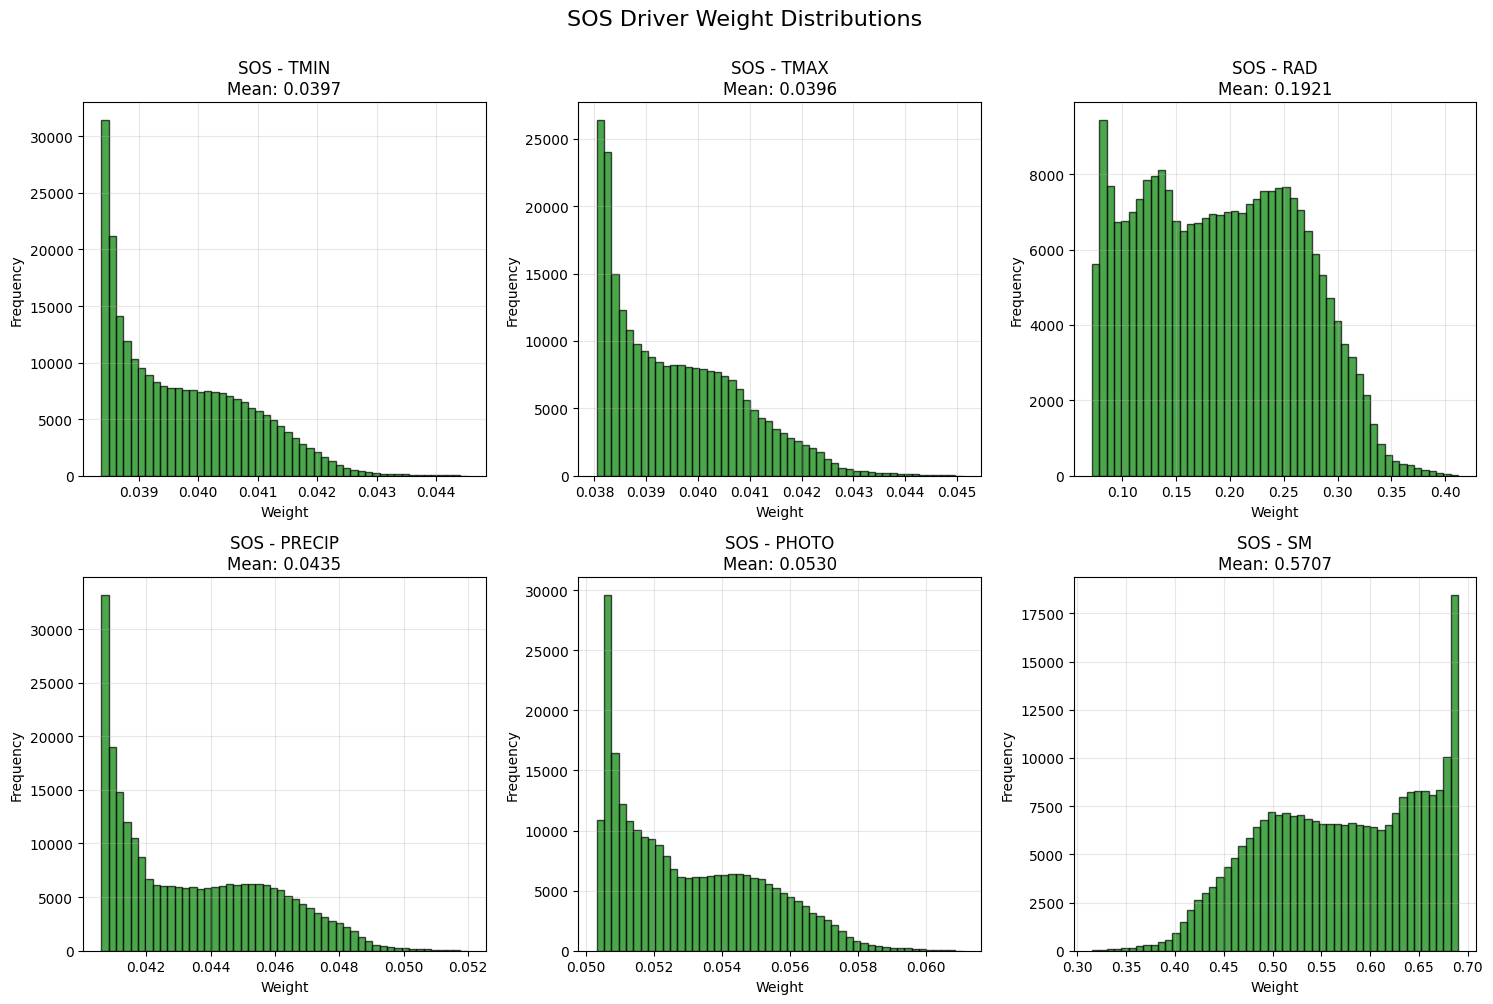

SOS Driver Weight Summary:
           hist_tmin      hist_tmax       hist_rad    hist_precip  \
count  252146.000000  252146.000000  252146.000000  252146.000000   
mean        0.039737       0.039582       0.192105       0.043473   
std         0.001121       0.001256       0.071835       0.002402   
min         0.038375       0.038045       0.071778       0.040609   
25%         0.038708       0.038444       0.130175       0.041226   
50%         0.039521       0.039340       0.190947       0.043001   
75%         0.040558       0.040453       0.249934       0.045384   
max         0.044526       0.045111       0.411945       0.051989   

          hist_photo        hist_sm  
count  252146.000000  252146.000000  
mean        0.053016       0.570702  
std         0.002135       0.081068  
min         0.050325       0.315048  
25%         0.051069       0.505299  
50%         0.052492       0.574696  
75%         0.054652       0.643552  
max         0.061078       0.689981  


In [30]:
# Plot driver weight distributions for SOS
if len(sos_driver_df) > 0:
    driver_cols = ["hist_tmin", "hist_tmax", "hist_rad", "hist_precip", "hist_photo", "hist_sm"]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(driver_cols):
        axes[idx].hist(sos_driver_df[col].dropna(), bins=50, alpha=0.7, color='green', edgecolor='black')
        axes[idx].set_title(f'SOS - {col.replace("hist_", "").upper()}\nMean: {sos_driver_df[col].mean():.4f}')
        axes[idx].set_xlabel('Weight')
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(True, alpha=0.3)
    
    plt.suptitle('SOS Driver Weight Distributions', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("SOS Driver Weight Summary:")
    print(sos_driver_df[driver_cols].describe())

In [ ]:
# Plot driver weight distributions for EOS
if len(eos_driver_df) > 0:
    driver_cols = ["hist_tmin", "hist_tmax", "hist_rad", "hist_precip", "hist_photo", "hist_sm"]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(driver_cols):
        axes[idx].hist(eos_driver_df[col].dropna(), bins=50, alpha=0.7, color='brown', edgecolor='black')
        axes[idx].set_title(f'EOS - {col.replace("hist_", "").upper()}\nMean: {eos_driver_df[col].mean():.4f}')
        axes[idx].set_xlabel('Weight')
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(True, alpha=0.3)
    
    plt.suptitle('EOS Driver Weight Distributions', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("EOS Driver Weight Summary:")
    print(eos_driver_df[driver_cols].describe())

## Step 13: Merge with Coordinates and Check for Missing Data

In [31]:
# Merge SOS drivers with coordinates
sos_coord_driver_df = pd.merge(coords, sos_driver_df, on="location", how="left")

print("SOS Data After Coordinate Merge:")
print(f"  Total locations in coords: {len(coords)}")
print(f"  Locations with SOS driver data: {len(sos_driver_df)}")
print(f"  Final merged DataFrame: {sos_coord_driver_df.shape}")

driver_cols = ["hist_tmin", "hist_tmax", "hist_rad", "hist_precip", "hist_photo", "hist_sm"]
missing_mask = sos_coord_driver_df[driver_cols].isnull().all(axis=1)
n_missing = missing_mask.sum()

print(f"\nMissing Data:")
print(f"  Locations with all drivers missing: {n_missing}")
print(f"  Percentage missing: {100 * n_missing / len(sos_coord_driver_df):.1f}%")

print(f"\nFirst few rows:")
sos_coord_driver_df.head(10)

SOS Data After Coordinate Merge:
  Total locations in coords: 3564
  Locations with SOS driver data: 252146
  Final merged DataFrame: (252147, 9)

Missing Data:
  Locations with all drivers missing: 1
  Percentage missing: 0.0%

First few rows:


,location,latitude,longitude,hist_tmin,hist_tmax,hist_rad,hist_precip,hist_photo,hist_sm
0,0,44.25,-118.25,0.040587,0.040580,0.261370,0.045899,0.054947,0.491787
1,0,44.25,-118.25,0.038535,0.038178,0.139186,0.041289,0.050934,0.633859
2,0,44.25,-118.25,0.038610,0.038353,0.159835,0.041944,0.051484,0.610716
3,0,44.25,-118.25,0.040374,0.040353,0.248833,0.045466,0.054806,0.506732
4,0,44.25,-118.25,0.040150,0.040123,0.243923,0.045111,0.054247,0.512320
5,0,44.25,-118.25,0.039968,0.039906,0.232782,0.044784,0.054055,0.525618
6,0,44.25,-118.25,0.039681,0.039605,0.222989,0.044280,0.053521,0.537023
7,0,44.25,-118.25,0.040814,0.040830,0.270293,0.046252,0.055316,0.481286
8,0,44.25,-118.25,0.038490,0.038151,0.136154,0.041195,0.050883,0.637171
9,0,44.25,-118.25,0.040265,0.040237,0.248475,0.045347,0.054429,0.506968


In [ ]:
# Merge EOS drivers with coordinates
eos_coord_driver_df = pd.merge(coords, eos_driver_df, on="location", how="left")

print("EOS Data After Coordinate Merge:")
print(f"  Total locations in coords: {len(coords)}")
print(f"  Locations with EOS driver data: {len(eos_driver_df)}")
print(f"  Final merged DataFrame: {eos_coord_driver_df.shape}")

missing_mask = eos_coord_driver_df[driver_cols].isnull().all(axis=1)
n_missing = missing_mask.sum()

print(f"\nMissing Data:")
print(f"  Locations with all drivers missing: {n_missing}")
print(f"  Percentage missing: {100 * n_missing / len(eos_coord_driver_df):.1f}%")

print(f"\nFirst few rows:")
eos_coord_driver_df.head(10)

## Step 14: Spatial Imputation of Missing Values

Fill missing driver values using nearby spatial locations.

In [32]:
def impute_nearby_values(
    df: pd.DataFrame,
    lat_range: float = 0.5,
    lon_range: float = 0.5,
    max_distance: float = 2.0,
) -> pd.DataFrame:
    """
    Impute missing driver values using nearby spatial locations.
    """
    driver_cols = [
        "hist_tmin",
        "hist_tmax",
        "hist_rad",
        "hist_precip",
        "hist_photo",
        "hist_sm",
    ]
    
    # Identify rows with missing data
    missing_mask = df[driver_cols].isnull().all(axis=1)
    n_missing = missing_mask.sum()
    
    if n_missing == 0:
        print("No missing values to impute")
        return df
    
    print(f"Found {n_missing} locations with missing data")
    
    # Create a copy to avoid modifying during iteration
    df_result = df.copy()
    filled_count = 0
    
    # For each row with data, find and fill nearby missing rows
    for idx, row in df.iterrows():
        if row[driver_cols].isnull().any():
            continue
        
        # Find nearby locations with missing data
        lat_match = (df["latitude"] >= row["latitude"] - lat_range) & (
            df["latitude"] <= row["latitude"] + lat_range
        )
        lon_match = (df["longitude"] >= row["longitude"] - lon_range) & (
            df["longitude"] <= row["longitude"] + lon_range
        )
        
        # Additional distance check
        lat_diff = np.abs(df["latitude"] - row["latitude"])
        lon_diff = np.abs(df["longitude"] - row["longitude"])
        dist = np.sqrt(lat_diff**2 + lon_diff**2)
        dist_match = dist <= max_distance
        
        # Combined mask
        nearby_missing = lat_match & lon_match & dist_match & missing_mask
        
        if nearby_missing.any():
            # Impute values
            df_result.loc[nearby_missing, driver_cols] = row[driver_cols].values
            filled_count += nearby_missing.sum()
    
    # Count remaining missing values
    n_remaining = df_result[driver_cols].isnull().all(axis=1).sum()
    print(f"After imputation: {n_remaining} locations still missing ({n_missing - n_remaining} filled)")
    
    return df_result

print("Imputing SOS missing values...")
sos_imputed_df = impute_nearby_values(sos_coord_driver_df)

print("\nImputing EOS missing values...")
#eos_imputed_df = impute_nearby_values(eos_coord_driver_df)

Imputing SOS missing values...
Found 1 locations with missing data


KeyboardInterrupt: 

## Step 15: Visualize Spatial Coverage

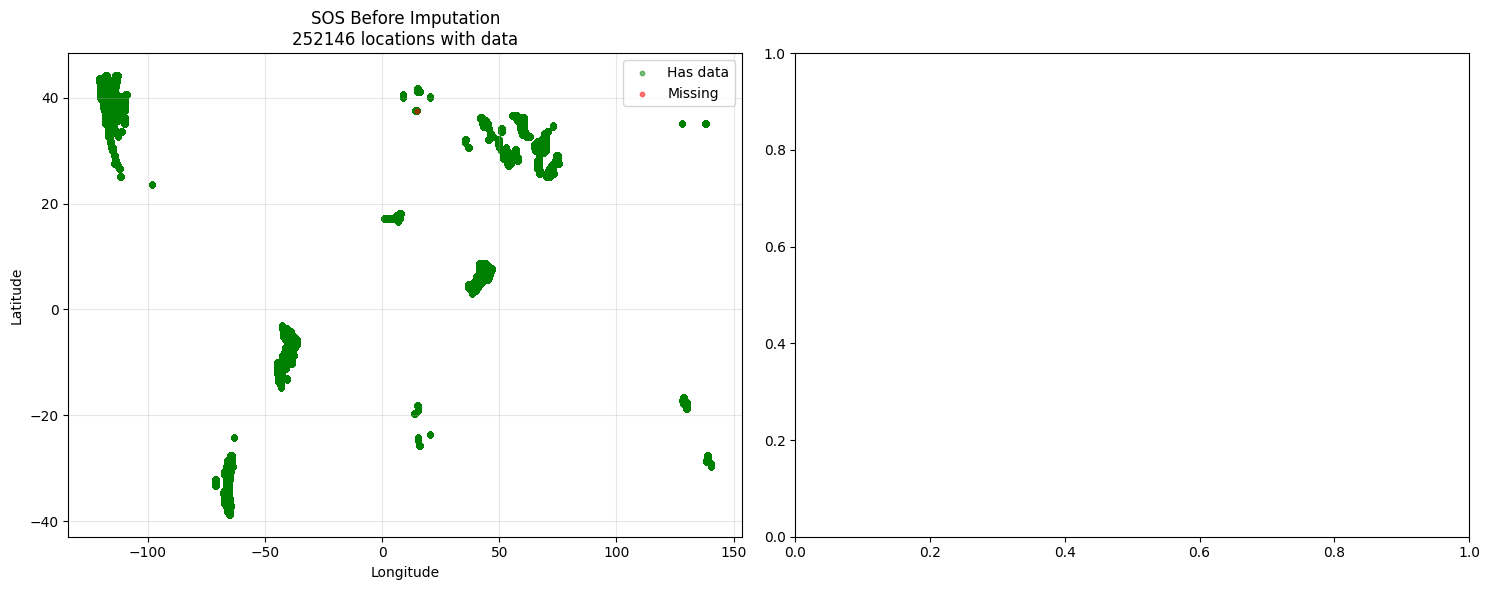

In [33]:
# Visualize spatial coverage for SOS
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Before imputation
has_data = ~sos_coord_driver_df[driver_cols].isnull().all(axis=1)
axes[0].scatter(
    sos_coord_driver_df.loc[has_data, 'longitude'],
    sos_coord_driver_df.loc[has_data, 'latitude'],
    c='green', s=10, alpha=0.5, label='Has data'
)
axes[0].scatter(
    sos_coord_driver_df.loc[~has_data, 'longitude'],
    sos_coord_driver_df.loc[~has_data, 'latitude'],
    c='red', s=10, alpha=0.5, label='Missing'
)
axes[0].set_title(f'SOS Before Imputation\n{has_data.sum()} locations with data')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].legend()
axes[0].grid(True, alpha=0.3)



plt.tight_layout()
plt.show()

In [ ]:
# Visualize spatial coverage for EOS
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Before imputation
has_data = ~eos_coord_driver_df[driver_cols].isnull().all(axis=1)
axes[0].scatter(
    eos_coord_driver_df.loc[has_data, 'longitude'],
    eos_coord_driver_df.loc[has_data, 'latitude'],
    c='brown', s=10, alpha=0.5, label='Has data'
)
axes[0].scatter(
    eos_coord_driver_df.loc[~has_data, 'longitude'],
    eos_coord_driver_df.loc[~has_data, 'latitude'],
    c='red', s=10, alpha=0.5, label='Missing'
)
axes[0].set_title(f'EOS Before Imputation\n{has_data.sum()} locations with data')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# After imputation
has_data_imp = ~eos_imputed_df[driver_cols].isnull().all(axis=1)
axes[1].scatter(
    eos_imputed_df.loc[has_data_imp, 'longitude'],
    eos_imputed_df.loc[has_data_imp, 'latitude'],
    c='brown', s=10, alpha=0.5, label='Has data'
)
axes[1].scatter(
    eos_imputed_df.loc[~has_data_imp, 'longitude'],
    eos_imputed_df.loc[~has_data_imp, 'latitude'],
    c='red', s=10, alpha=0.5, label='Missing'
)
axes[1].set_title(f'EOS After Imputation\n{has_data_imp.sum()} locations with data')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 16: Final Data Quality Check

In [ ]:
# SOS data quality
n_complete_sos = (~sos_imputed_df[driver_cols].isnull().any(axis=1)).sum()
print("SOS Data Quality:")
print(f"  Total locations: {len(sos_imputed_df)}")
print(f"  Complete records: {n_complete_sos} ({100*n_complete_sos/len(sos_imputed_df):.1f}%)")
print(f"\nMissing values per driver:")
for col in driver_cols:
    n_missing = sos_imputed_df[col].isnull().sum()
    print(f"  {col}: {n_missing} ({100*n_missing/len(sos_imputed_df):.1f}%)")

print("\n" + "="*50 + "\n")

# EOS data quality
n_complete_eos = (~eos_imputed_df[driver_cols].isnull().any(axis=1)).sum()
print("EOS Data Quality:")
print(f"  Total locations: {len(eos_imputed_df)}")
print(f"  Complete records: {n_complete_eos} ({100*n_complete_eos/len(eos_imputed_df):.1f}%)")
print(f"\nMissing values per driver:")
for col in driver_cols:
    n_missing = eos_imputed_df[col].isnull().sum()
    print(f"  {col}: {n_missing} ({100*n_missing/len(eos_imputed_df):.1f}%)")

## Step 17: Save Output Files

In [ ]:
# Save SOS driver data
sos_output_path = f"{OUTPUT_BASE}_SOS.csv"
sos_imputed_df.to_csv(sos_output_path, index=False)
print(f"✓ SOS driver data saved to: {sos_output_path}")
print(f"  Shape: {sos_imputed_df.shape}")

# Save EOS driver data
eos_output_path = f"{OUTPUT_BASE}_EOS.csv"
eos_imputed_df.to_csv(eos_output_path, index=False)
print(f"\n✓ EOS driver data saved to: {eos_output_path}")
print(f"  Shape: {eos_imputed_df.shape}")

print("\n" + "="*50)
print("Driver data extraction complete!")
print("="*50)

## Summary

This notebook walked through the entire driver data extraction pipeline:

1. **Data Loading**: Loaded test data, predictions, and coordinates
2. **Data Preparation**: Created analysis DataFrame with temporal features
3. **Phenology Detection**: Used CSIF slope analysis to identify SOS and EOS samples
4. **Driver Extraction**: Extracted climate driver importance weights from attention scores
5. **Spatial Imputation**: Filled missing values using nearby locations
6. **Quality Checks**: Validated data completeness and spatial coverage
7. **Output**: Saved driver data to CSV files for mapping

The diagnostic outputs at each step help understand:
- Data quality and completeness
- Phenology detection performance
- Driver weight distributions
- Spatial coverage patterns
- Impact of imputation strategies